## 12. Loading the pretrained model - ResNet50

### Modifying the network according to the number of classes and freezing the inner layers for transfer learning

In [ ]:
# Initialize the model
# Define the modified ResNet50 model
class ModifiedResNet(nn.Module):
    def __init__(self, num_classes=5):
        super(ModifiedResNet, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)  # Modify for custom classes

    def forward(self, x):
        return self.resnet(x)


# Freeze all layers except layer4 and fc
for param in model.parameters():
    param.requires_grad = False
for param in model.resnet.layer4.parameters():
    param.requires_grad = True
for param in model.resnet.fc.parameters():
    param.requires_grad = True

model = ModifiedResNet(num_classes=5).to(device)



## 13. Transforming the dataset and splitting into training, testing and validation

In [1]:
from torchvision import datasets, transforms, models
import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset
DATA_DIR = '/content/data'
dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)

# Train-validation-test split
total_size = len(dataset)
train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"

## 14. Training the model

In [3]:

# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    list(model.resnet.layer4.parameters()) + list(model.resnet.fc.parameters()), lr=0.001
)

# Training loop with loss recording
num_epochs = 20

# Lists to store training and validation loss over epochs
train_losses = []
val_losses = []

#Training
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = train_correct / train_total
    train_losses.append(running_loss / len(train_loader))

    # validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            v_loss = loss_fn(val_outputs, val_labels)
            val_loss += v_loss.item()
            _, predicted = torch.max(val_outputs, 1)
            val_total += val_labels.size(0)
            val_correct += (predicted == val_labels).sum().item()

    val_accuracy = val_correct / val_total
    val_losses.append(val_loss / len(val_loader))

    # Print progress for each epoch
    print(
        f"Epoch {epoch + 1}/{num_epochs}, "
        f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracy:.4f}, "
        f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}"
    )

# Testing loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")


Epoch 1/20, Train Loss: 0.7872, Train Accuracy: 0.6884, Val Loss: 0.7222, Val Accuracy: 0.7245
Epoch 2/20, Train Loss: 0.5249, Train Accuracy: 0.8025, Val Loss: 0.6092, Val Accuracy: 0.7547
Epoch 3/20, Train Loss: 0.3670, Train Accuracy: 0.8610, Val Loss: 0.6622, Val Accuracy: 0.7618
Epoch 4/20, Train Loss: 0.2110, Train Accuracy: 0.9268, Val Loss: 0.8940, Val Accuracy: 0.7541
Epoch 5/20, Train Loss: 0.1356, Train Accuracy: 0.9523, Val Loss: 0.7574, Val Accuracy: 0.7788
Epoch 6/20, Train Loss: 0.1167, Train Accuracy: 0.9583, Val Loss: 0.5931, Val Accuracy: 0.8134
Epoch 7/20, Train Loss: 0.0548, Train Accuracy: 0.9817, Val Loss: 0.8041, Val Accuracy: 0.8145
Epoch 8/20, Train Loss: 0.0646, Train Accuracy: 0.9771, Val Loss: 0.8466, Val Accuracy: 0.7700
Epoch 9/20, Train Loss: 0.0439, Train Accuracy: 0.9848, Val Loss: 0.7397, Val Accuracy: 0.8139
Epoch 10/20, Train Loss: 0.0507, Train Accuracy: 0.9828, Val Loss: 0.6599, Val Accuracy: 0.8249
Epoch 11/20, Train Loss: 0.0597, Train Accuracy: 

### Plotting the confusion matrix

Confusion Matrix:
 [[777  90   4   2   2]
 [133 336   9   4   0]
 [ 21  23 126   1   0]
 [  5   8   0 138   2]
 [  6   3   5   0 129]]


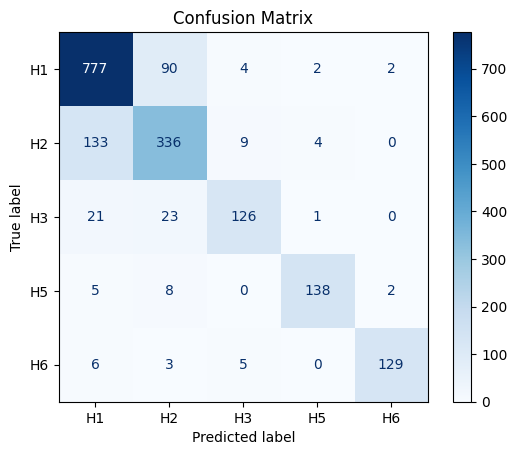

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Initialize variables for predictions and true labels
all_preds = []
all_labels = []

# Testing loop with predictions accumulation
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())  # Append predictions to list
        all_labels.extend(labels.cpu().numpy())   # Append true labels to list

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

# Display confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
